In [1]:
import json
import tensorflow as tf

In [2]:
x = tf.Variable([1, 2], dtype=tf.float32)

In [3]:
@tf.function
def f(x):
    return tf.square(x)

In [4]:
with tf.GradientTape() as tape:
    y = f(x)
tape.gradient(y, x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 4.], dtype=float32)>

In [5]:
x = tf.constant([5, 5], dtype=tf.float16, name='fixed array')

In [6]:
with tf.GradientTape() as tape:
    tape.watch(x)
    y = f(x)
tape.gradient(y, x)

<tf.Tensor: shape=(2,), dtype=float16, numpy=array([10., 10.], dtype=float16)>

In [7]:
x = tf.constant([[1, 1], [5, 5]], dtype=tf.float16, name='fixed array')

In [8]:
with tf.GradientTape() as tape:
    tape.watch(x)
    y = f(x)
tape.gradient(y, x)

<tf.Tensor: shape=(2, 2), dtype=float16, numpy=
array([[ 2.,  2.],
       [10., 10.]], dtype=float16)>

In [9]:
tf.sign([-5,5])

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([-1,  1], dtype=int32)>

## Example with Mobilenet

In [10]:
@tf.function
def preprocess_input(input_image):
    image = tf.cast(input_image, tf.float32)
    resized_image = tf.image.resize(image, (224, 224))
    return tf.keras.applications.mobilenet_v2.preprocess_input(resized_image)

In [11]:
def get_model():
    input_layer = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    processed_images = tf.keras.layers.Lambda(preprocess_input)(input_layer)
    output = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')(processed_images)
    return tf.keras.Model(inputs=[input_layer], outputs=[output])

In [12]:
model = get_model()

In [13]:
image_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg', 
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
)
image_raw = tf.io.read_file(image_path)
images = tf.expand_dims(tf.image.decode_image(image_raw), axis=0)

In [14]:
images.shape, images.dtype

(TensorShape([1, 577, 700, 3]), tf.uint8)

In [15]:
tf.keras.applications.mobilenet_v2.decode_predictions(
    model.predict(images)
)

[[('n02099712', 'Labrador_retriever', 0.4181848),
  ('n02109961', 'Eskimo_dog', 0.055355117),
  ('n02091244', 'Ibizan_hound', 0.035056952),
  ('n02099601', 'golden_retriever', 0.027119756),
  ('n02091831', 'Saluki', 0.018688856)]]

In [16]:
tf.saved_model.save(
    model,
    export_dir='temp',
    signatures=None
)

INFO:tensorflow:Assets written to: temp/assets


In [17]:
def create_adversarial_pattern(input_image, input_label, model):
    loss_function = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_function(input_label, prediction)

    # Get the gradients of the loss w.r.t the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [18]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.expand_dims(
    tf.one_hot(labrador_retriever_index, 1000),
    axis=0
)

In [19]:
# in order to compute gradients properly, we should preprocess the image before
signed_gradients = create_adversarial_pattern(
    preprocess_input(images),
    label,
    tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
)

In [20]:
tf.keras.applications.mobilenet_v2.decode_predictions(
    tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet').predict(
        preprocess_input(images)
    )
)

[[('n02099712', 'Labrador_retriever', 0.4181848),
  ('n02109961', 'Eskimo_dog', 0.055355117),
  ('n02091244', 'Ibizan_hound', 0.035056952),
  ('n02099601', 'golden_retriever', 0.027119756),
  ('n02091831', 'Saluki', 0.018688856)]]

In [21]:
tf.keras.applications.mobilenet_v2.decode_predictions(
    tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet').predict(
        preprocess_input(images) + 1/255*signed_gradients
    )
)

[[('n02091244', 'Ibizan_hound', 0.0890426),
  ('n02091831', 'Saluki', 0.08489862),
  ('n02109961', 'Eskimo_dog', 0.0351581),
  ('n02110806', 'basenji', 0.03108664),
  ('n02092339', 'Weimaraner', 0.030016018)]]

## Custom Example

In [52]:
!pip3 install matplotlib

     |████████████████████████████████| 11.6 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 3.1 MB/s eta 0:00:01


In [53]:
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

In [54]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [55]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [56]:
batch_size = 32
img_height = 180
img_width = 180

In [57]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [59]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [60]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [61]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [62]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [63]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(tf.math.reduce_min(first_image), tf.math.reduce_max(first_image))

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [64]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [67]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 202s 2s/step - loss: 1.9167 - accuracy: 0.2712 - val_loss: 1.3120 - val_accuracy: 0.4755
Epoch 2/10
92/92 [==============================] - 177s 2s/step - loss: 1.1898 - accuracy: 0.5099 - val_loss: 1.0420 - val_accuracy: 0.5749
Epoch 3/10
92/92 [==============================] - 177s 2s/step - loss: 0.8927 - accuracy: 0.6630 - val_loss: 0.9655 - val_accuracy: 0.6444
Epoch 4/10
92/92 [==============================] - 175s 2s/step - loss: 0.7300 - accuracy: 0.7264 - val_loss: 0.9772 - val_accuracy: 0.6253
Epoch 5/10
92/92 [==============================] - 177s 2s/step - loss: 0.4925 - accuracy: 0.8254 - val_loss: 1.1049 - val_accuracy: 0.6090
Epoch 6/10
92/92 [==============================] - 175s 2s/step - loss: 0.3034 - accuracy: 0.8986 - val_loss: 1.2212 - val_accuracy: 0.6185
Epoch 7/10
92/92 [==============================] - 176s 2s/step - loss: 0.1820 - accuracy: 0.9485 - val_loss: 1.4463 - val_accuracy: 0.6172
Epoch 8/10
92

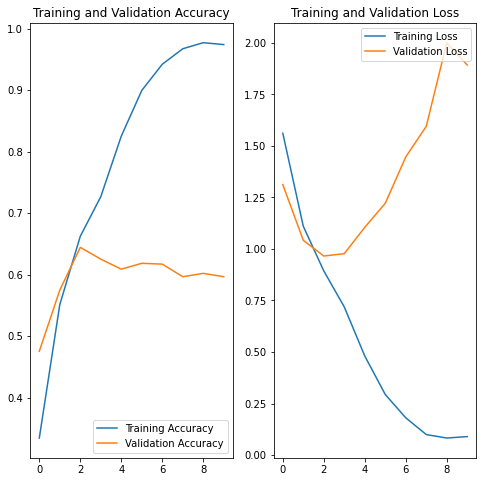

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

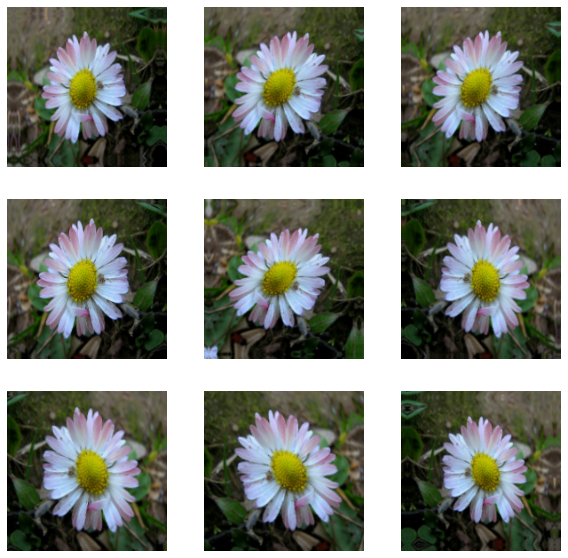

In [70]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [71]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 201s 2s/step - loss: 1.4386 - accuracy: 0.3566 - val_loss: 1.0554 - val_accuracy: 0.5681
Epoch 2/15
92/92 [==============================] - 190s 2s/step - loss: 1.0252 - accuracy: 0.5921 - val_loss: 1.2165 - val_accuracy: 0.5381
Epoch 3/15
92/92 [==============================] - 190s 2s/step - loss: 0.9599 - accuracy: 0.6169 - val_loss: 0.9835 - val_accuracy: 0.6104
Epoch 4/15
92/92 [==============================] - 190s 2s/step - loss: 0.8816 - accuracy: 0.6530 - val_loss: 0.8366 - val_accuracy: 0.6730
Epoch 5/15
92/92 [==============================] - 193s 2s/step - loss: 0.7916 - accuracy: 0.6912 - val_loss: 0.7822 - val_accuracy: 0.6744
Epoch 6/15
92/92 [==============================] - 190s 2s/step - loss: 0.7609 - accuracy: 0.7158 - val_loss: 0.9913 - val_accuracy: 0.6267
Epoch 7/15
92/92 [==============================] - 193s 2s/step - loss: 0.7651 - accuracy: 0.7067 - val_loss: 0.7671 - val_accuracy: 0.6812
Epoch 8/15
92

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)